In [4]:
import pandas as pd
import pandahouse as ph
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
from causalimpact import CausalImpact

## Метрики, которые могли измениться

Вероятнее всего должны измениться аудиторные количественные метрики, поэтому предположу, что это будут:

1. Количество просмотров
2. Количество новых постов
3. CTR
4. DAU
5. Среднее количество просмотров на пользователя
6. Среднее количество лайков на пользователя

In [6]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20240120',
'user':'student',
'password':'dpo_python_2020'
}

q = """
select time, dau, likes, views, ctr, avg_likes, avg_views, new_posts
from
(SELECT toDate(time) as time, uniqExact(user_id) as dau,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    round(likes/views, 3) as ctr,
    round(likes/uniqExact(user_id), 3) as avg_likes,
    round(views/uniqExact(user_id), 3) as avg_views
FROM simulator_20240120.feed_actions
WHERE toDate(time) between '2023-12-29' and '2024-02-01'
GROUP BY time) t1

join

(select time, count(post_id) as new_posts
from
(select toDate(min(time)) as time, post_id
from simulator_20240120.feed_actions
group by post_id)
group by time) t2

using (time)
"""

df = ph.read_clickhouse(q, connection=connection)
df.set_index('time', inplace=True, drop=True)

In [7]:
df.head(10)

,dau,likes,views,ctr,avg_likes,avg_views,new_posts
time,,,,,,,
2023-12-29,12651,89429,420498,0.213,7.069,33.238,105
2023-12-30,12968,79586,383221,0.208,6.137,29.551,53
2023-12-31,13201,77761,366238,0.212,5.891,27.743,69
2024-01-01,13928,97688,458803,0.213,7.014,32.941,80
2024-01-02,14540,114920,549607,0.209,7.904,37.800,72
2024-01-03,14774,120932,581472,0.208,8.185,39.358,83
2024-01-04,14276,126519,583554,0.217,8.862,40.877,89
2024-01-05,13996,109499,493534,0.222,7.824,35.263,69
2024-01-06,14517,112304,531289,0.211,7.736,36.598,57


## Посмотрим на графики метрик за неделю до флешмоба и во время этой недели

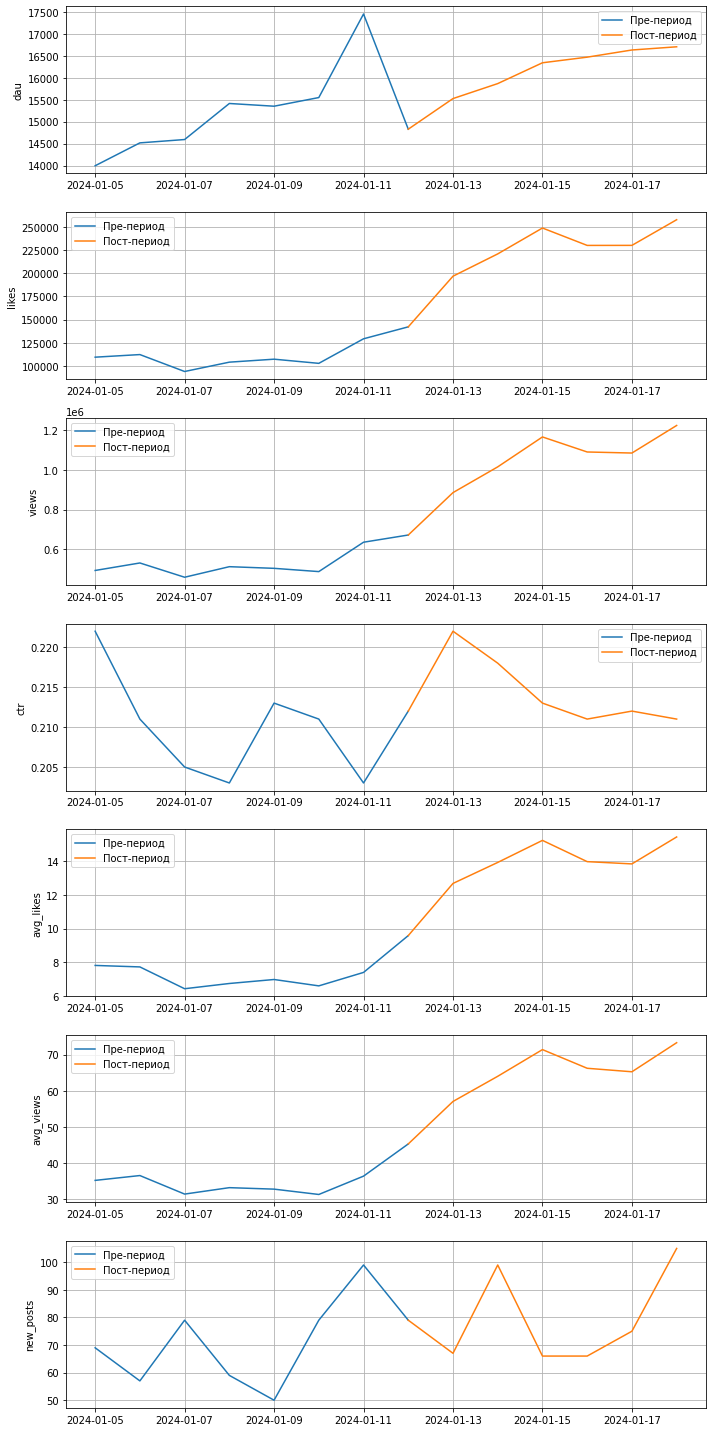

In [8]:
pre_period = df.loc['2024-01-05':'2024-01-12']

post_period = df.loc['2024-01-12':'2024-01-18']

fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(10, 20))

for i, col in enumerate(df.columns):
    axes[i].plot(pre_period.index, pre_period[col], linestyle='-', label='Пре-период')
    axes[i].plot(post_period.index, post_period[col], linestyle='-', label='Пост-период')
    axes[i].set_ylabel(col)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()




Судя по графикам, флешмоб больше всего повлиял на метрики:

количество лайков

количество просмотров

среднее количество лайков на пользователя

среднее количество просмотров на пользователя

In [9]:
#Проверим корреляцию метрик
df.corr()

,dau,likes,views,ctr,avg_likes,avg_views,new_posts
dau,1.000000,0.248523,0.270662,-0.280333,-0.059822,-0.043337,0.029388
likes,0.248523,1.000000,0.997667,0.204081,0.951097,0.954507,0.147169
views,0.270662,0.997667,1.000000,0.139022,0.941190,0.949231,0.148725
ctr,-0.280333,0.204081,0.139022,1.000000,0.304749,0.240973,-0.001263
avg_likes,-0.059822,0.951097,0.941190,0.304749,1.000000,0.997633,0.145515
avg_views,-0.043337,0.954507,0.949231,0.240973,0.997633,1.000000,0.147514
new_posts,0.029388,0.147169,0.148725,-0.001263,0.145515,0.147514,1.000000


## Метрика "количество просмотров"

In [10]:
impact_count_views = CausalImpact(data = pd.Series(df.views), pre_period = ['2023-12-29', '2024-01-11'],
                     post_period = ['2024-01-12', '2024-02-01'])

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2024-02-07 14:35:16.216143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2024-02-07 14:35:16.216514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2024-02-07 14:35:16.227911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2024-02-07 14:35:16.228087: I tens

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


2024-02-07 14:35:16.538892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:35:16.562730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:35:17.175841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


2024-02-07 14:35:28.780174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2024-02-07 14:35:28.862415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

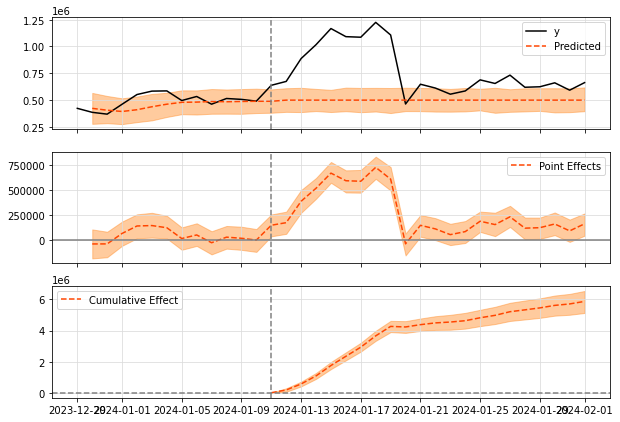

In [11]:
impact_count_views.plot()

In [12]:
print(impact_count_views.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    777106.12          16319229.0
Prediction (s.d.)         497224.72 (19158.42)10441719.0 (402326.97)
95% CI                    [459751.46, 534851.12][9654780.43, 11231873.5]

Absolute effect (s.d.)    279881.41 (19158.42)5877510.0 (402326.97)
95% CI                    [242255.01, 317354.67][5087355.5, 6664448.57]

Relative effect (s.d.)    56.29% (3.85%)     56.29% (3.85%)
95% CI                    [48.72%, 63.83%]   [48.72%, 63.83%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [13]:
print(impact_count_views.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 777106.12. By contrast, in the absence of an
intervention, we would have expected an average response of 497224.72.
The 95% interval of this counterfactual prediction is [459751.46, 534851.12].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 279881.41 with a 95% interval of
[242255.01, 317354.67]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 16319229.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 10441719.0. The 95% interval of this prediction is [9654780.43, 11231873.5].


The above results are given in terms of absolute num

## Метрика "Количество новых постов"

In [14]:
impact_cnt_new_posts = CausalImpact(data = pd.Series(df.new_posts), pre_period = ['2023-12-29', '2024-01-11'],
                     post_period = ['2024-01-12', '2024-02-01'])

2024-02-07 14:35:40.019643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:35:40.042808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:35:40.559956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:

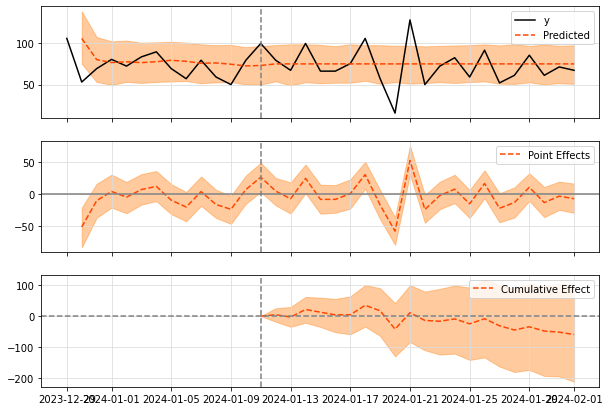

In [15]:
impact_cnt_new_posts.plot()

In [16]:
print(impact_cnt_new_posts.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    71.81              1508.0
Prediction (s.d.)         74.63 (4.13)       1567.14 (86.63)
95% CI                    [66.7, 82.87]      [1400.6, 1740.2]

Absolute effect (s.d.)    -2.82 (4.13)       -59.14 (86.63)
95% CI                    [-11.06, 5.11]     [-232.2, 107.4]

Relative effect (s.d.)    -3.77% (5.53%)     -3.77% (5.53%)
95% CI                    [-14.82%, 6.85%]   [-14.82%, 6.85%]

Posterior tail-area probability p: 0.24
Posterior prob. of a causal effect: 76.32%

For more details run the command: print(impact.summary('report'))


In [17]:
print(impact_cnt_new_posts.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 71.81. In the absence of an
intervention, we would have expected an average response of 74.63.
The 95% interval of this counterfactual prediction is [66.7, 82.87].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -2.82 with a 95% interval of
[-11.06, 5.11]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1508.0.
Had the intervention not taken place, we would have expected
a sum of 1567.14. The 95% interval of this prediction is [1400.6, 1740.2].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed a decrease of -3

## Метрика CTR

In [18]:
impact_CTR = CausalImpact(data = pd.Series(df.ctr), pre_period = ['2023-12-29', '2024-01-11'],
                     post_period = ['2024-01-12', '2024-02-01'])

2024-02-07 14:36:03.801056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:36:03.825061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:36:04.337553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:

2024-02-07 14:36:15.082244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2024-02-07 14:36:15.159134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

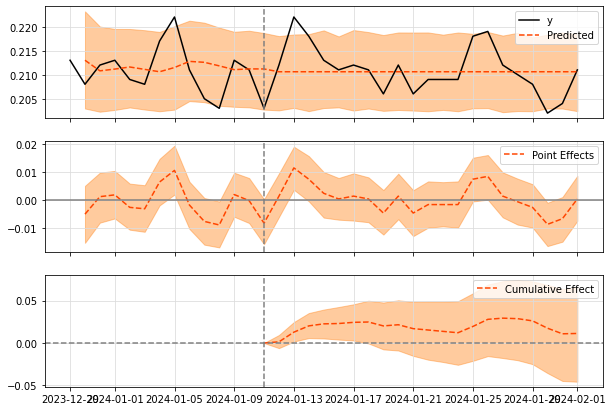

In [19]:
impact_CTR.plot()

In [20]:
print(impact_CTR.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               4.43
Prediction (s.d.)         0.21 (0.0)         4.42 (0.03)
95% CI                    [0.21, 0.21]       [4.37, 4.48]

Absolute effect (s.d.)    0.0 (0.0)          0.01 (0.03)
95% CI                    [-0.0, 0.0]        [-0.04, 0.07]

Relative effect (s.d.)    0.25% (0.62%)      0.25% (0.62%)
95% CI                    [-0.95%, 1.47%]    [-0.95%, 1.47%]

Posterior tail-area probability p: 0.35
Posterior prob. of a causal effect: 65.33%

For more details run the command: print(impact.summary('report'))


In [21]:
print(impact_CTR.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.21. In the absence of an
intervention, we would have expected an average response of 0.21.
The 95% interval of this counterfactual prediction is [0.21, 0.21].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.0 with a 95% interval of
[-0.0, 0.0]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 4.43.
Had the intervention not taken place, we would have expected
a sum of 4.42. The 95% interval of this prediction is [4.37, 4.48].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +0.25%. The 95%
in

## Метрика DAU

In [22]:
impact_dau = CausalImpact(data = pd.Series(df.dau), pre_period = ['2023-12-29', '2024-01-11'],
                     post_period = ['2024-01-12', '2024-02-01'])

2024-02-07 14:36:27.896980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:36:27.921122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:36:28.450377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:

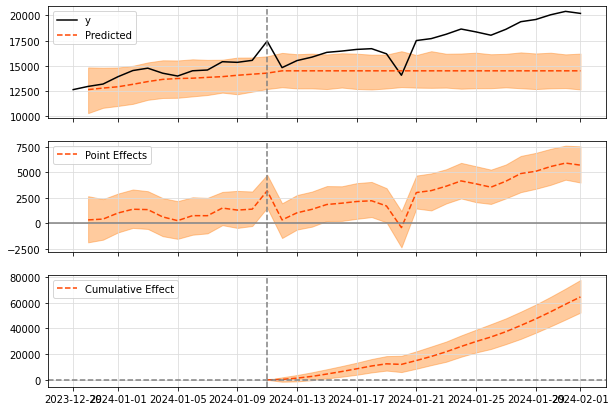

In [23]:
impact_dau.plot()

In [24]:
 print(impact_dau.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    17585.24           369290.0
Prediction (s.d.)         14511.74 (278.2)   304746.59 (5842.1)
95% CI                    [13968.23, 15058.73][293332.74, 316233.35]

Absolute effect (s.d.)    3073.5 (278.2)     64543.41 (5842.1)
95% CI                    [2526.51, 3617.01] [53056.65, 75957.26]

Relative effect (s.d.)    21.18% (1.92%)     21.18% (1.92%)
95% CI                    [17.41%, 24.92%]   [17.41%, 24.92%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [25]:
 print(impact_dau.summary('report')) 

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 17585.24. By contrast, in the absence of an
intervention, we would have expected an average response of 14511.74.
The 95% interval of this counterfactual prediction is [13968.23, 15058.73].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 3073.5 with a 95% interval of
[2526.51, 3617.01]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 369290.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 304746.59. The 95% interval of this prediction is [293332.74, 316233.35].


The above results are given in terms of absolute numbers. In relativ

## Метрика "Среднее количество просмотров на пользователя"

In [26]:
impact_avg_views = CausalImpact(data = pd.Series(df.avg_views), pre_period = ['2023-12-29', '2024-01-11'],
                     post_period = ['2024-01-12', '2024-02-01'])

2024-02-07 14:37:04.416238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:37:04.444880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:37:04.974178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:

2024-02-07 14:37:16.268972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2024-02-07 14:37:16.354665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

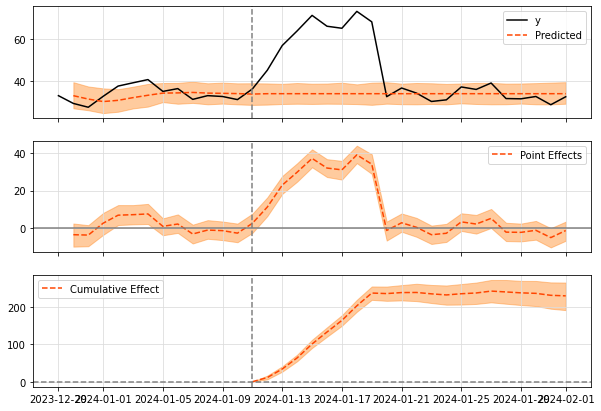

In [27]:
impact_avg_views.plot()

In [28]:
print(impact_avg_views.summary()) 

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    45.13              947.63
Prediction (s.d.)         34.18 (0.82)       717.76 (17.21)
95% CI                    [32.55, 35.77]     [683.65, 751.1]

Absolute effect (s.d.)    10.95 (0.82)       229.87 (17.21)
95% CI                    [9.36, 12.57]      [196.53, 263.98]

Relative effect (s.d.)    32.03% (2.4%)      32.03% (2.4%)
95% CI                    [27.38%, 36.78%]   [27.38%, 36.78%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [29]:
print(impact_avg_views.summary('report')) 

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 45.13. By contrast, in the absence of an
intervention, we would have expected an average response of 34.18.
The 95% interval of this counterfactual prediction is [32.55, 35.77].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 10.95 with a 95% interval of
[9.36, 12.57]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 947.63.
By contrast, had the intervention not taken place, we would have expected
a sum of 717.76. The 95% interval of this prediction is [683.65, 751.1].


The above results are given in terms of absolute numbers. In relative
terms, the response variable

## Метрика "Среднее количество лайков на пользователя"

In [30]:
impact_avg_likes = CausalImpact(data = pd.Series(df.avg_likes), pre_period = ['2023-12-29', '2024-01-11'],
                     post_period = ['2024-01-12', '2024-02-01'])

2024-02-07 14:37:29.633754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:37:29.655503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:37:30.156610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-02-07 14:

2024-02-07 14:37:41.456833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2024-02-07 14:37:41.537982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

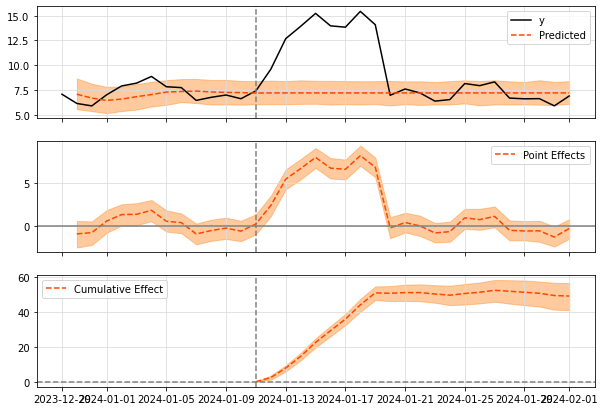

In [31]:
impact_avg_likes.plot()

In [32]:
print(impact_avg_likes.summary()) 

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    9.55               200.48
Prediction (s.d.)         7.2 (0.2)          151.18 (4.11)
95% CI                    [6.83, 7.59]       [143.38, 159.48]

Absolute effect (s.d.)    2.35 (0.2)         49.3 (4.11)
95% CI                    [1.95, 2.72]       [41.0, 57.1]

Relative effect (s.d.)    32.61% (2.72%)     32.61% (2.72%)
95% CI                    [27.12%, 37.77%]   [27.12%, 37.77%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [33]:
print(impact_avg_likes.summary('report')) 

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 9.55. By contrast, in the absence of an
intervention, we would have expected an average response of 7.2.
The 95% interval of this counterfactual prediction is [6.83, 7.59].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 2.35 with a 95% interval of
[1.95, 2.72]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 200.48.
By contrast, had the intervention not taken place, we would have expected
a sum of 151.18. The 95% interval of this prediction is [143.38, 159.48].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showe

## Все метрики, за исключением "количество новых постов" и DAU имели краткосрочный эффект и спустя несколько дней возвращались к спрогнозированным значениям. Метрика DAU росла и до флешмоба, и после (за исключением 20 января, где был резкий обвал), но до флешмоба она росла почти параллельно предсказанию, а после - рост оказался выше прогноза (Хотя скорее всего имеет место естественный рост пользователей, потому что прогноз после флешмоба показывал одно значение). Метрика "количество новых постов" имела разброс и до, и после флешмоба, поэтому можно сделать вывод, что флешмоб не оказал влияния на данную метрику.

## Можно с уверенностью сделать вывод, что флешмоб не имел долгосрочных эффектов